# Singular Value Decomposition (SVD)

## Application to Detrending Time Series

In time series analysis, identifying and removing trends is essential for uncovering the underlying scaling behavior. However, “trend” is not uniquely defined, and real-world data often mix deterministic trends with stochastic fluctuations and periodic components.

One well-known method, **Multifractal Detrended Fluctuation Analysis (MF-DFA)**, is powerful but not foolproof: it struggles with intrinsic periodicities. When sinusoidal components are present, MF-DFA produces *spurious crossovers* in the fluctuation function, leading to unreliable scaling exponents.
👉 To fix this, trends and periodic components must be attenuated before applying MF-DFA.

### Why SVD?

Several preprocessing methods exist (Fourier filtering, EMD, etc.). I use **Singular Value Decomposition (SVD)** because:

* It suppresses both periodic and quasi-periodic trends.
* It handles signals with multiple peaks in the power spectrum better than alternatives.
* It provides a clear separation between dominant structured components (large singular values) and stochastic fluctuations (smaller singular values).

Following the approach in [Xu et al., Phys. Rev. E 95, 062802 (2017)](https://doi.org/10.1103/PhysRevE.95.062802), I combine **SVD preprocessing with MF-DFA** to extract reliable multiscaling behavior in nanofriction data.

### How SVD Works (Intuition)

Every matrix $M$ can be decomposed into:

$$
M = U \Sigma V^*
$$

where $U$ and $V$ are rotations, and $\Sigma$ contains the singular values (rescaling factors).

* Large singular values → dominant patterns (often trends/periodicities).
* Smaller singular values → noise and fine-scale fluctuations.

By reconstructing the signal with only selected components, we filter out unwanted trends.

<p align="center">
  <img width="500" src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/bb/Singular-Value-Decomposition.svg/800px-Singular-Value-Decomposition.svg.png" alt="SVD decomposition illustration">
</p>

### Implementation

I provide [notebook code in this repo](./notebooks/svd_detrending.ipynb) to demonstrate:

1. Computing the SVD.
2. Removing periodic components from synthetic and experimental signals.
3. Applying MF-DFA on the detrended series.

**Practical Insight:**
In my experiments, reconstructing the time series while omitting the top singular components effectively removes periodicities, yielding clean fluctuation functions without artificial crossovers.

Perfect — if your goal is to make the repo **accessible but still advanced**, then adding an “intuitive paragraph” for each method is a great idea. This way, someone who only knows basic stats (like regression, means, variance) can still follow along.

Every matrix $M$ can be seen as a linear transformation. It is shown that this transformation can be decomposed in three sub-transformations (using three another matrices $U$, $\Sigma$, and $V^*$): 1. rotation, 2. re-scaling, 3. rotation (See https://en.wikipedia.org/wiki/Singular_value_decomposition for more details. The follwoing figure is from this page).





In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd  # singular value decomposition

%matplotlib inline

In [2]:
np.random.seed(0)

## Sapmle time series (noise + trend)

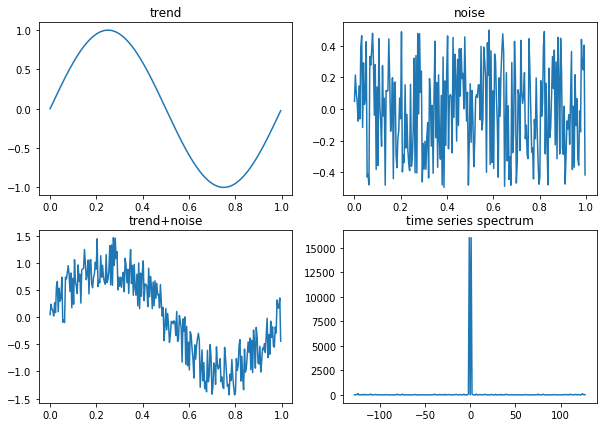

In [3]:
N = 256  # length of the time series
t = np.arange(N)/N

trend = np.sin(2*np.pi*t)
noise = np.random.rand(N) - 0.5

sp = np.abs(np.fft.fft(trend+noise))**2

time_step = t[1]-t[0]
freqs = np.fft.fftfreq(N, time_step)
idx = np.argsort(freqs)


plt.rcParams["figure.figsize"]=[10,7]

fig,a =  plt.subplots(2,2)
a[0][0].plot(t,trend)
a[0][0].set_title('trend')

a[0][1].plot(t,noise)
a[0][1].set_title('noise')

a[1][0].plot(t,trend+noise)
a[1][0].set_title('trend+noise')

a[1][1].plot(freqs[idx], sp[idx])
#a[1][1].plot(freq, sp)
a[1][1].set_title('time series spectrum')
plt.show()

# SVD Algorithm

## Step 1
For a series $\{x_i|i=1,...,N\}$ with periodic or quasiperiodic
trends, the first step is to find the number of periodic or quasiperiodic
components of the data series using its power spectrum. This number
is denoted by $p$.

In [4]:
np.where(sp == max(sp))

(array([  1, 255]),)

In [5]:
freqs[1]

1.0

In [6]:
# find the first three largest values in power spectrum
A = [i for i in sorted(sp,reverse=True)][0:6]
A = A[0],A[2],A[4]
A

(16006.51038232545, 129.74228988651058, 97.24276653452048)

In [7]:
# find the corresponding index
index = [np.where(sp == i) for i in A]
index
largest_index = index[0][0][0],index[1][0][0],index[2][0][0]
largest_index

(1, 124, 2)

In [8]:
# find the corresponding frequencies
[freqs[i] for i in largest_index]

[1.0, 124.0, 2.0]

In [9]:
# the number of periodic or quasiperiodic components of the data series
# using its power spectrum that need to be removed in deterending 

p = 3

## Step 2

Construct the matrix $\Gamma = (\gamma_1 ,\gamma_2 , \cdots ,\gamma_d )^T$  , where $\gamma_k =
(x_k ,x_{k+1} , . . . ,x_{k+N−d})$ and the superscript "$T$" represents
the transpose operator. The dimension $d$ of the matrix $\Gamma$ is
called the embedding dimension. Note that, for a power-law
series, the embedding dimension should be chosen much larger
than the number of frequency components $p$.

In [10]:
d = 128 

In [11]:
T = np.zeros( (N-d+1,d) )

for k in range(d): 
    gamma = trend[k:k+N-d+1] + noise[k:k+N-d+1]
    T[:,k] = gamma

In [12]:
T.shape

(129, 128)

## Step 3
Determine singular values in descending order by applying
the SVD on the matrix $\Gamma$. Singular value decomposition
of the matrix $\Gamma_{(N-d+1) \times d}$ is given by $\Gamma = U \Sigma V^T$ ,
where $U_{(N-d+1) \times (N-d+1)}$ and $V_{d \times d}$ are two orthogonal matrices
and $\Sigma_{(N-d+1) \times d}$ is the diagonal matrix whose eigenvalues are the desired singular values.

In [13]:
# SVD
U, s, VT = svd(T)
#print('U=',U)
#print('s=',s)
#print('VT=', VT)

In [14]:
# create m x n Sigma matrix
Sigma = np.zeros((T.shape[0], T.shape[1]))
# populate Sigma with n x n diagonal matrix
Sigma[:T.shape[1], :T.shape[1]] = np.diag(s)

#U.dot(Sigma.dot(VT))-T

## Step 4

Construct the filtered matrix $\Gamma^{new} = U \Sigma^{new} V^T$ with the
new matrix $\Sigma^{new}$ , which is obtained by setting the first $2p + 1$
eigenvalues of to zero.

In [15]:
s_new = s
s_new[:2*p+1] = 0

Sigma_new = np.zeros((T.shape[0], T.shape[1]))
Sigma_new[:T.shape[1], :T.shape[1]] = np.diag(s_new)

In [16]:
T_new = U.dot(Sigma_new.dot(VT))

## Step 5

Compute detrended data $\{x_i^∗\}$, elements of the filtered
matrix $\Gamma^∗$ , by mapping $\Gamma^∗$ back onto a one-dimensional series

In [17]:
x_new = np.zeros( (T.shape[0]+T.shape[1]-1) )
for i in range(T.shape[0]):
    for j in range(T.shape[1]):
        x_new[i+j] = T_new[i][j]

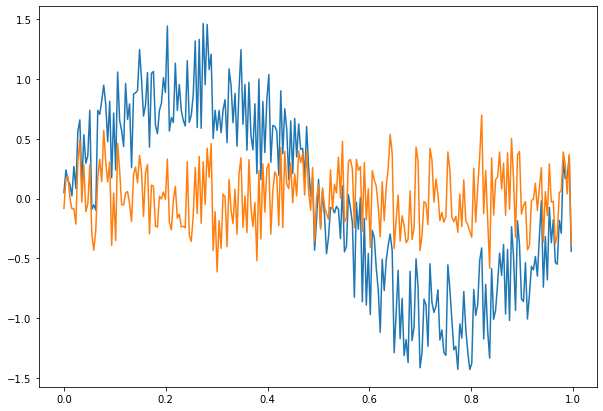

In [18]:
plt.plot(t, trend+noise, t, x_new)
plt.show()

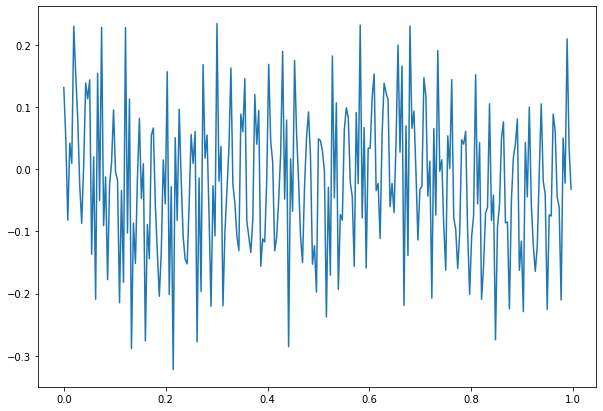

In [19]:
plt.plot(t,noise-x_new)
plt.show()